In [1]:
# Install additional libraries
!pip install seaborn scikit-learn keras-tuner opencv-python-headless

# Import libraries
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive, files
import warnings
warnings.filterwarnings('ignore')

# Import ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
import keras_tuner as kt

# Setup logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [2]:
# ### 1. Enhanced Configuration and Setup

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
class Config:
    # Paths
    DRIVE_ZIP = '/content/drive/MyDrive/capstone_project/dataset/mst_1.zip'
    EXTRACT_DIR = '/content/dataset'
    RESIZED_DIR = '/content/resized'
    SEGMENTED_DIR = '/content/segmented'
    MODEL_SAVE_PATH = '/content/drive/MyDrive/skin_tone_model_improved.h5'

    # Model parameters
    IMG_SIZE = (224, 224)  # Increased for better detail
    BATCH_SIZE = 16  # Reduced for memory efficiency
    NUM_CLASSES = 10

    # Training parameters
    LEARNING_RATE = 1e-4
    EPOCHS = 50
    PATIENCE = 10
    VALIDATION_SPLIT = 0.2

    # Augmentation parameters
    ROTATION_RANGE = 30
    WIDTH_SHIFT_RANGE = 0.2
    HEIGHT_SHIFT_RANGE = 0.2
    SHEAR_RANGE = 0.2
    ZOOM_RANGE = 0.2

    # Focal loss parameters
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0

    # Cross-validation
    CV_FOLDS = 5

config = Config()

In [17]:
# ### 2. Enhanced Dataset Preparation and Validation

# %%
def validate_dataset():
    """Validate dataset before processing"""
    if not os.path.exists(config.DRIVE_ZIP):
        raise FileNotFoundError(f"Dataset tidak ditemukan: {config.DRIVE_ZIP}")

    # Check file size
    file_size = os.path.getsize(config.DRIVE_ZIP) / (1024*1024)  # MB
    logging.info(f"Dataset size: {file_size:.2f} MB")

    if file_size < 10:
        logging.warning("Dataset mungkin terlalu kecil untuk training yang robust")


In [18]:
def improved_skin_segmentation(img):
    """Enhanced skin segmentation using multiple color spaces"""
    # Convert to different color spaces
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Multiple thresholding approaches
    # YCrCb mask
    mask1 = cv2.inRange(ycrcb, (0, 133, 77), (255, 173, 127))

    # HSV mask for different skin tones
    mask2 = cv2.inRange(hsv, (0, 48, 80), (20, 255, 255))
    mask3 = cv2.inRange(hsv, (160, 48, 80), (180, 255, 255))

    # LAB mask
    mask4 = cv2.inRange(lab, (0, 130, 130), (255, 150, 150))

    # Combine masks
    combined_mask = cv2.bitwise_or(mask1, mask2)
    combined_mask = cv2.bitwise_or(combined_mask, mask3)
    combined_mask = cv2.bitwise_or(combined_mask, mask4)

    # Enhanced morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    # Remove noise
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_small)
    # Fill holes
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_large)

    # Apply Gaussian blur to soften edges
    combined_mask = cv2.GaussianBlur(combined_mask, (5, 5), 0)

    # Create output image
    result = cv2.bitwise_and(img, img, mask=combined_mask)

    # Fill background with white instead of black for better contrast
    bg = np.full_like(img, 255)
    result = result + cv2.bitwise_and(bg, bg, mask=~combined_mask)

    return result


In [19]:
def prepare_dataset():
    """Enhanced dataset preparation with validation"""
    validate_dataset()

    # Extract dataset
    if not os.path.exists(config.EXTRACT_DIR):
        os.makedirs(config.EXTRACT_DIR)
        logging.info("Extracting dataset...")
        with zipfile.ZipFile(config.DRIVE_ZIP, 'r') as z:
            z.extractall(config.EXTRACT_DIR)
        logging.info("Dataset extracted successfully")

    def process_images_enhanced(src_dir, dst_dir, process_fn=None):
        """Enhanced image processing with better error handling"""
        os.makedirs(dst_dir, exist_ok=True)
        processed_count = 0
        error_count = 0

        for class_name in os.listdir(src_dir):
            class_dir = os.path.join(src_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            dst_class_dir = os.path.join(dst_dir, class_name)
            os.makedirs(dst_class_dir, exist_ok=True)

            class_processed = 0
            for img_name in os.listdir(class_dir):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                img_path = os.path.join(class_dir, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("Could not load image")

                    # Check image dimensions
                    if img.shape[0] < 50 or img.shape[1] < 50:
                        raise ValueError("Image too small")

                    if process_fn:
                        img = process_fn(img)

                    output_path = os.path.join(dst_class_dir, img_name)
                    cv2.imwrite(output_path, img)
                    processed_count += 1
                    class_processed += 1

                except Exception as e:
                    error_count += 1
                    logging.warning(f"Error processing {img_path}: {str(e)}")

            logging.info(f"Class {class_name}: {class_processed} images processed")

        logging.info(f"Total processed: {processed_count}, Errors: {error_count}")

    # Resize images
    logging.info("Resizing images...")
    process_images_enhanced(
        config.EXTRACT_DIR,
        config.RESIZED_DIR,
        lambda x: cv2.resize(x, config.IMG_SIZE, interpolation=cv2.INTER_LANCZOS4)
    )

    # Enhanced skin segmentation
    logging.info("Applying enhanced skin segmentation...")
    process_images_enhanced(config.RESIZED_DIR, config.SEGMENTED_DIR, improved_skin_segmentation)

    logging.info("Dataset preprocessing completed successfully")


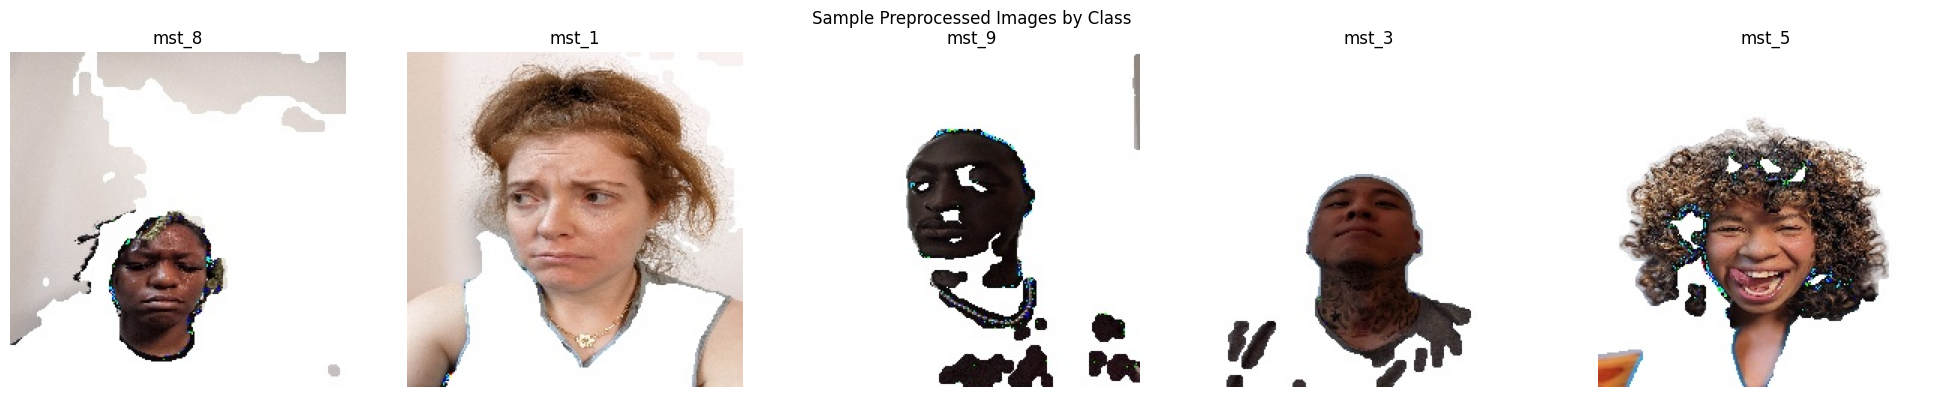

In [20]:
def validate_preprocessing():
    """Validate preprocessing results"""
    if not os.path.exists(config.SEGMENTED_DIR):
        logging.error("Segmented directory not found")
        return

    classes = [d for d in os.listdir(config.SEGMENTED_DIR)
               if os.path.isdir(os.path.join(config.SEGMENTED_DIR, d))]

    if len(classes) != config.NUM_CLASSES:
        logging.warning(f"Expected {config.NUM_CLASSES} classes, found {len(classes)}")

    # Visualize sample from each class
    plt.figure(figsize=(20, 4))
    for i, class_name in enumerate(classes[:5]):  # Show first 5 classes
        class_dir = os.path.join(config.SEGMENTED_DIR, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if images:
            img_path = os.path.join(class_dir, images[0])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(1, 5, i+1)
            plt.imshow(img_rgb)
            plt.title(f'{class_name}')
            plt.axis('off')

    plt.suptitle('Sample Preprocessed Images by Class')
    plt.tight_layout()
    plt.show()

# Execute preprocessing
prepare_dataset()
validate_preprocessing()


In [21]:
# ### 3. Enhanced Data Preparation and Analysis

# %%
def create_dataframe():
    """Create dataframe with enhanced validation"""
    data = []

    for class_name in os.listdir(config.SEGMENTED_DIR):
        class_dir = os.path.join(config.SEGMENTED_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue

        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            # Validate image can be loaded
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    data.append({
                        'path': img_path,
                        'label': class_name,
                        'filename': img_name
                    })
            except:
                continue

    df = pd.DataFrame(data)# Validate minimum samples per class
    class_counts = df['label'].value_counts()
    min_samples = class_counts.min()

    if min_samples < 10:
        logging.warning(f"Some classes have very few samples (minimum: {min_samples})")

    return df

def analyze_dataset(df):
    """Comprehensive dataset analysis"""
    print("="*50)
    print("DATASET ANALYSIS")
    print("="*50)

    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Average samples per class: {len(df) / df['label'].nunique():.1f}")

    print("\nClass distribution:")
    class_counts = df['label'].value_counts().sort_index()
    print(class_counts)

    # Visualize class distribution
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='label', order=class_counts.index)
    plt.title('Class Distribution')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Class Distribution (Pie Chart)')

    plt.tight_layout()
    plt.show()

    # Check for class imbalance
    imbalance_ratio = class_counts.max() / class_counts.min()
    if imbalance_ratio > 3:
        logging.warning(f"Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")

    return class_counts


DATASET ANALYSIS
Total samples: 4140
Number of classes: 10
Average samples per class: 414.0

Class distribution:
label
mst_1     407
mst_10    413
mst_2     426
mst_3     386
mst_4     433
mst_5     405
mst_6     418
mst_7     400
mst_8     417
mst_9     435
Name: count, dtype: int64


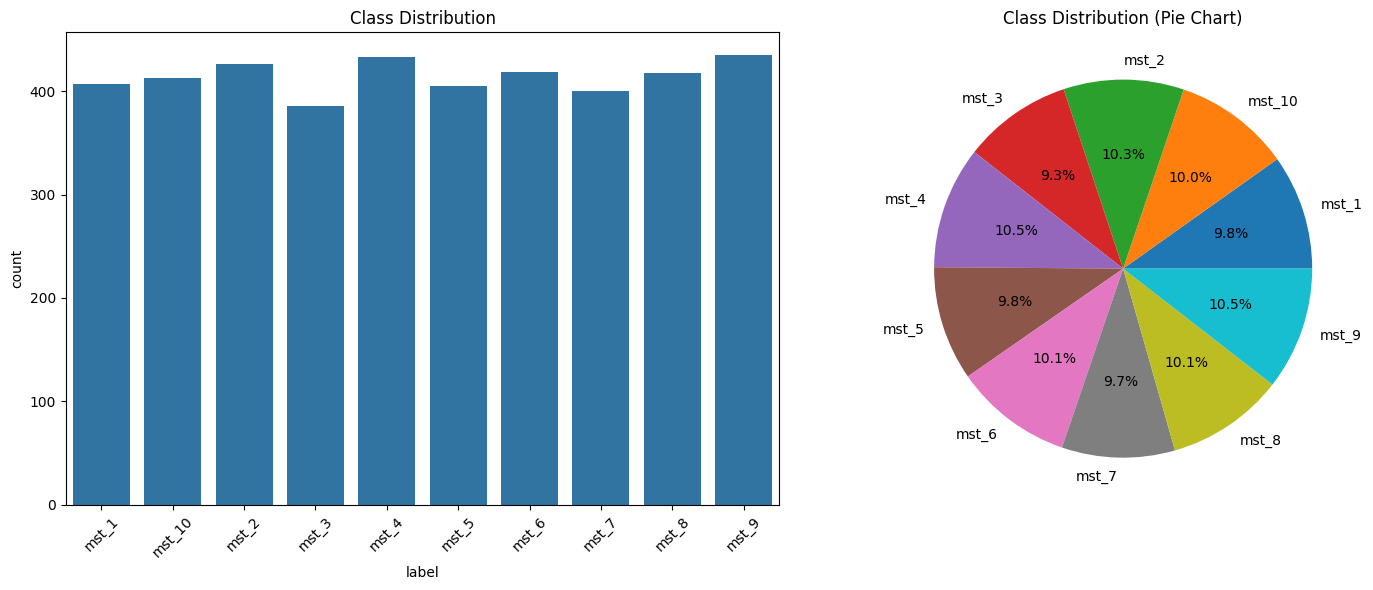


Training samples: 3312
Validation samples: 828

Class weights: {0: np.float64(1.0159509202453987), 1: np.float64(1.0036363636363637), 2: np.float64(0.9712609970674487), 3: np.float64(1.0718446601941747), 4: np.float64(0.9572254335260115), 5: np.float64(1.0222222222222221), 6: np.float64(0.9916167664670659), 7: np.float64(1.035), 8: np.float64(0.9916167664670659), 9: np.float64(0.9517241379310345)}


In [22]:
# Create and analyze dataset
df = create_dataframe()
class_counts = analyze_dataset(df)

# Enhanced train-validation split
train_df, val_df = train_test_split(
    df,
    test_size=config.VALIDATION_SPLIT,
    stratify=df['label'],
    random_state=42
)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

In [23]:
# ### 4. Enhanced Model Architecture and Training

# %%
# Enhanced data augmentation
def create_data_generators():
    """Create enhanced data generators"""
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=config.ROTATION_RANGE,
        width_shift_range=config.WIDTH_SHIFT_RANGE,
        height_shift_range=config.HEIGHT_SHIFT_RANGE,
        shear_range=config.SHEAR_RANGE,
        zoom_range=config.ZOOM_RANGE,
        horizontal_flip=True,
        vertical_flip=False,  # Usually not good for faces
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.2,
        fill_mode='constant',
        cval=1.0  # White background
    )

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    val_gen = val_datagen.flow_from_dataframe(
        val_df,
        x_col='path',
        y_col='label',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    return train_gen, val_gen

train_gen, val_gen = create_data_generators()


Found 3312 validated image filenames belonging to 10 classes.
Found 828 validated image filenames belonging to 10 classes.


In [24]:
# Enhanced focal loss implementation
def focal_loss(alpha=0.25, gamma=2.0):
    """Enhanced focal loss implementation"""
    def loss_fn(y_true, y_pred):
        # Convert to one-hot if needed
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=config.NUM_CLASSES)
        y_true = tf.cast(y_true, tf.float32)

        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Compute focal loss
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma)
        focal_loss = weight * ce

        return tf.reduce_sum(focal_loss, axis=1)

    return loss_fn

def create_enhanced_model(base_model_name='MobileNetV2'):
    """Create enhanced model architecture"""
    # Choose base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            input_shape=(*config.IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(
            input_shape=(*config.IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )

    # Freeze base model initially
    base_model.trainable = False

    # Enhanced architecture
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # First dense block
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Second dense block
        layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(config.NUM_CLASSES, activation='softmax')
    ])

    return model, base_model


In [25]:
# Create model
model, base_model = create_enhanced_model('MobileNetV2')

# Compile model
model.compile(
    optimizer=Adam(learning_rate=config.LEARNING_RATE),
    loss=focal_loss(alpha=config.FOCAL_ALPHA, gamma=config.FOCAL_GAMMA),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

print("Model Architecture:")
model.summary()

# Enhanced callbacks
def create_callbacks():
    """Create enhanced callbacks"""
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=config.PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=config.PATIENCE//2,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            'best_model_temp.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        callbacks.TensorBoard(
            log_dir='logs',
            histogram_freq=1,
            write_graph=True,
            write_images=True
        )
    ]

    return callbacks_list

model_callbacks = create_callbacks()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055,946 (11.66 MB)

 Trainable params: 793,866 (3.03 MB)

 Non-trainable params: 2,262,080 (8.63 MB)

In [26]:
# ### 5. Training with Fine-tuning

# %%
# Phase 1: Train with frozen base model
print("Phase 1: Training with frozen base model...")
history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.EPOCHS//2,
    class_weight=class_weight_dict,
    callbacks=model_callbacks,
    verbose=1
)

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning with unfrozen layers...")
base_model.trainable = True

# Fine-tune from the top layers of the base model
fine_tune_at = len(base_model.layers) - 20

# Freeze bottom layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=config.LEARNING_RATE/10),
    loss=focal_loss(alpha=config.FOCAL_ALPHA, gamma=config.FOCAL_GAMMA),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)


Phase 1: Training with frozen base model...
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3360 - loss: 10.8653 - sparse_top_k_categorical_accuracy: 0.7384
Epoch 1: val_accuracy improved from -inf to 0.92150, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 85s 320ms/step - accuracy: 0.3369 - loss: 10.8629 - sparse_top_k_categorical_accuracy: 0.7389 - val_accuracy: 0.9215 - val_loss: 9.4065 - val_sparse_top_k_categorical_accuracy: 0.9855 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7905 - loss: 9.0872 - sparse_top_k_categorical_accuracy: 0.9741
Epoch 2: val_accuracy improved from 0.92150 to 0.94928, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - accuracy: 0.7906 - loss: 9.0853 - sparse_top_k_categorical_accuracy: 0.9741 - val_accuracy: 0.9493 - val_loss: 7.8644 - val_sparse_top_k_categorical_accuracy: 0.9976 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8794 - loss: 7.5263 - sparse_top_k_categorical_accuracy: 0.9916
Epoch 3: val_accuracy improved from 0.94928 to 0.96860, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.8795 - loss: 7.5245 - sparse_top_k_categorical_accuracy: 0.9916 - val_accuracy: 0.9686 - val_loss: 6.4049 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9180 - loss: 6.0972 - sparse_top_k_categorical_accuracy: 0.9937
Epoch 4: val_accuracy improved from 0.96860 to 0.97705, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.9180 - loss: 6.0957 - sparse_top_k_categorical_accuracy: 0.9937 - val_accuracy: 0.9771 - val_loss: 5.1152 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9405 - loss: 4.8492 - sparse_top_k_categorical_accuracy: 0.9959
Epoch 5: val_accuracy improved from 0.97705 to 0.98430, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.9404 - loss: 4.8479 - sparse_top_k_categorical_accuracy: 0.9959 - val_accuracy: 0.9843 - val_loss: 4.0225 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9402 - loss: 3.8054 - sparse_top_k_categorical_accuracy: 0.9957
Epoch 6: val_accuracy improved from 0.98430 to 0.98792, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.9402 - loss: 3.8043 - sparse_top_k_categorical_accuracy: 0.9957 - val_accuracy: 0.9879 - val_loss: 3.1318 - val_sparse_top_k_categorical_accuracy: 0.9988 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9484 - loss: 2.9580 - sparse_top_k_categorical_accuracy: 0.9985
Epoch 7: val_accuracy improved from 0.98792 to 0.99034, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.9484 - loss: 2.9571 - sparse_top_k_categorical_accuracy: 0.9985 - val_accuracy: 0.9903 - val_loss: 2.4196 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9599 - loss: 2.2825 - sparse_top_k_categorical_accuracy: 0.9990
Epoch 8: val_accuracy did not improve from 0.99034
207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step - accuracy: 0.9599 - loss: 2.2818 - sparse_top_k_categorical_accuracy: 0.9990 - val_accuracy: 0.9855 - val_loss: 1.8644 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9627 - loss: 1.7560 - sparse_top_k_categorical_accuracy: 0.9997
Epoch 9: val_accuracy improved from 0.99034 to 0.99275, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 273ms/step - accuracy: 0.9627 - loss: 1.7555 - sparse_top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9928 - val_loss: 1.4325 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9665 - loss: 1.3561 - sparse_top_k_categorical_accuracy: 0.9991
Epoch 10: val_accuracy improved from 0.99275 to 0.99396, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.9665 - loss: 1.3557 - sparse_top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9940 - val_loss: 1.1089 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9658 - loss: 1.0559 - sparse_top_k_categorical_accuracy: 0.9996
Epoch 11: val_accuracy did not improve from 0.99396
207/207 ━━━━━━━━━━━━━━━━━━━━ 55s 268ms/step - accuracy: 0.9658 - loss: 1.0556 - sparse_top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9928 - val_loss: 0.8689 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9643 - loss: 0.8306 - sparse_top_k_categorical_accuracy: 0.9999
Epoch 12: val_accuracy improved from 0.99396 to 0.99517, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 273ms/step - accuracy: 0.9643 - loss: 0.8303 - sparse_top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9952 - val_loss: 0.6891 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9646 - loss: 0.6700 - sparse_top_k_categorical_accuracy: 0.9969
Epoch 13: val_accuracy did not improve from 0.99517
207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 273ms/step - accuracy: 0.9646 - loss: 0.6699 - sparse_top_k_categorical_accuracy: 0.9969 - val_accuracy: 0.9928 - val_loss: 0.5566 - val_sparse_top_k_categorical_accuracy: 0.9988 - learning_rate: 1.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9648 - loss: 0.5404 - sparse_top_k_categorical_accuracy: 0.9994
Epoch 14: val_accuracy improved from 0.99517 to 0.99879, saving model to best_model_temp.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.9648 - loss: 0.5402 - sparse_top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.9988 - val_loss: 0.4582 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9685 - loss: 0.4486 - sparse_top_k_categorical_accuracy: 0.9997
Epoch 15: val_accuracy did not improve from 0.99879
207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 268ms/step - accuracy: 0.9686 - loss: 0.4485 - sparse_top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9952 - val_loss: 0.3806 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9775 - loss: 0.3708 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.99879
207/207 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.9774 - loss: 0.3708 - sparse_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9952 - val

In [27]:
# Continue training
history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.EPOCHS//2,
    initial_epoch=len(history_1.history['loss']),
    class_weight=class_weight_dict,
    callbacks=model_callbacks,
    verbose=1
)

# Combine histories
def combine_histories(hist1, hist2):
    """Combine training histories"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

full_history = combine_histories(history_1, history_2)


Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9244 - loss: 0.4851 - sparse_top_k_categorical_accuracy: 0.9954
Epoch 25: val_accuracy did not improve from 0.99879
207/207 ━━━━━━━━━━━━━━━━━━━━ 80s 291ms/step - accuracy: 0.9244 - loss: 0.4851 - sparse_top_k_categorical_accuracy: 0.9954 - val_accuracy: 0.9976 - val_loss: 0.4520 - val_sparse_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 25.


In [ ]:
# ### 6. Enhanced Model Evaluation

# %%
def plot_training_history(history):
    """Enhanced training history visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0,0].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0,0].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss
    axes[0,1].plot(history['loss'], label='Train Loss', linewidth=2)
    axes[0,1].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Top-k accuracy
    if 'sparse_top_k_categorical_accuracy' in history:
        axes[1,0].plot(history['sparse_top_k_categorical_accuracy'],
                       label='Train Top-k Acc', linewidth=2)
        axes[1,0].plot(history['val_sparse_top_k_categorical_accuracy'],
                       label='Val Top-k Acc', linewidth=2)
    axes[1,0].set_title('Top-k Accuracy')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Learning rate (if available)
    axes[1,1].plot(range(len(history['loss'])),
                   [config.LEARNING_RATE] * len(history['loss']),
                   label='Learning Rate', linewidth=2)
    axes[1,1].set_title('Learning Rate Schedule')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Learning Rate')
    axes[1,1].set_yscale('log')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


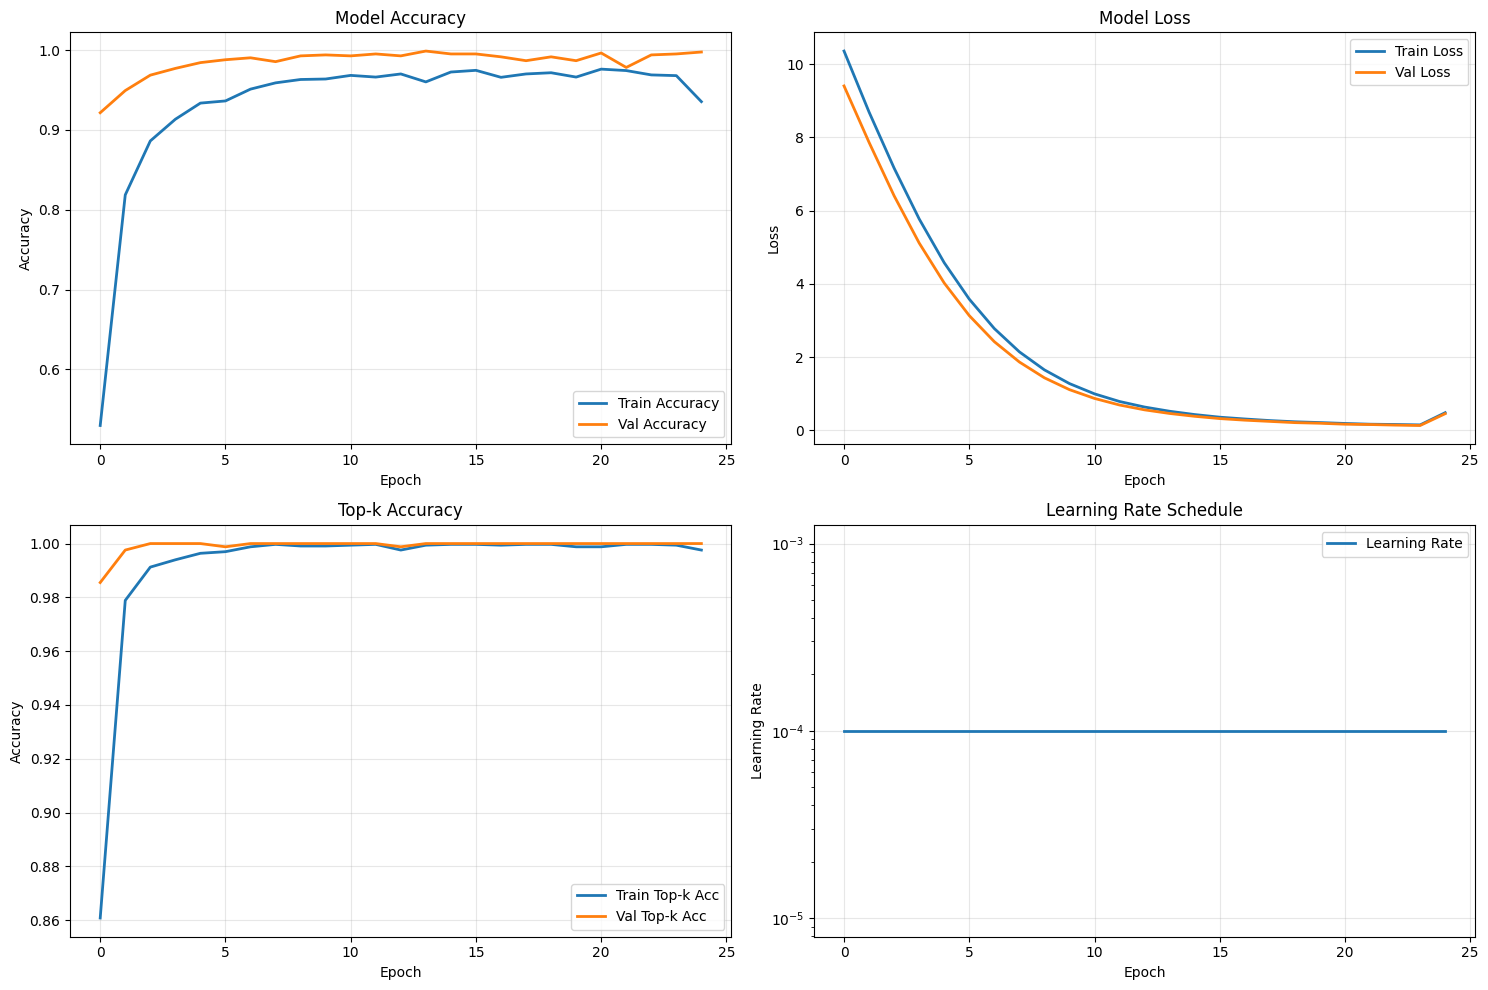

Generating predictions...
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step

Overall Accuracy: 0.9976

Detailed Classification Report:
              precision    recall  f1-score   support

       mst_1     1.0000    1.0000    1.0000        81
      mst_10     1.0000    0.9880    0.9939        83
       mst_2     1.0000    1.0000    1.0000        85
       mst_3     1.0000    1.0000    1.0000        77
       mst_4     1.0000    1.0000    1.0000        87
       mst_5     1.0000    1.0000    1.0000        81
       mst_6     1.0000    1.0000    1.0000        84
       mst_7     1.0000    1.0000    1.0000        80
       mst_8     1.0000    0.9880    0.9939        83
       mst_9     0.9775    1.0000    0.9886        87

    accuracy                         0.9976       828
   macro avg     0.9978    0.9976    0.9977       828
weighted avg     0.9976    0.9976    0.9976       828



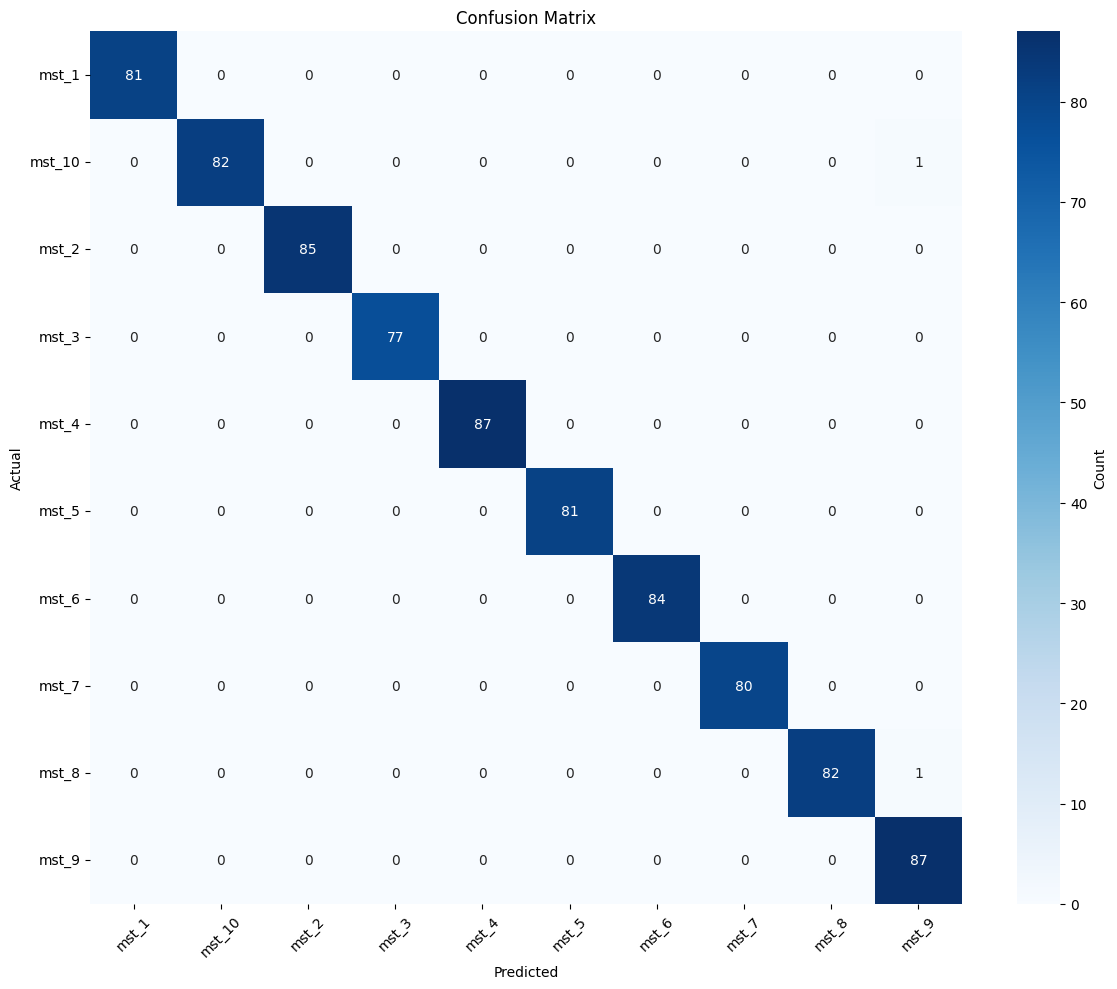

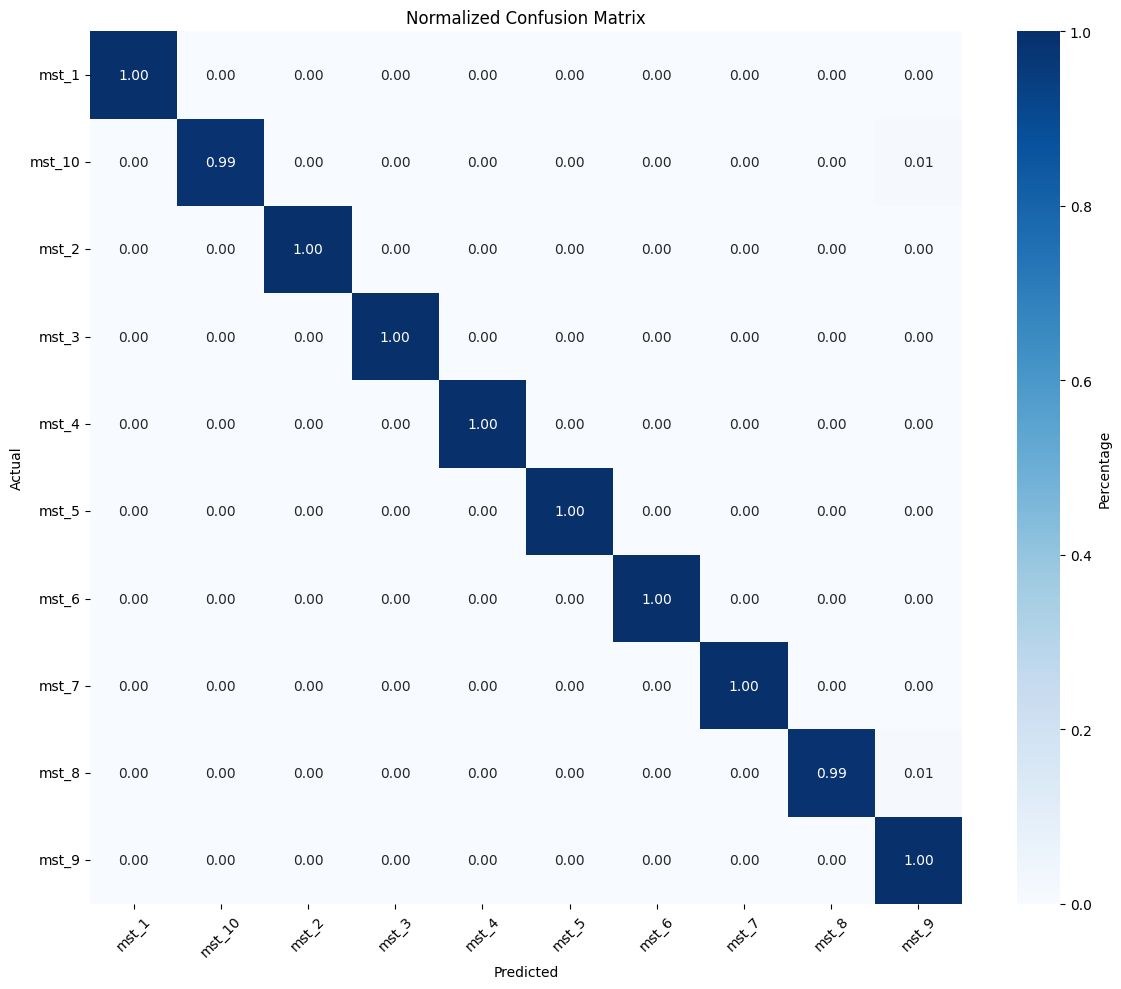

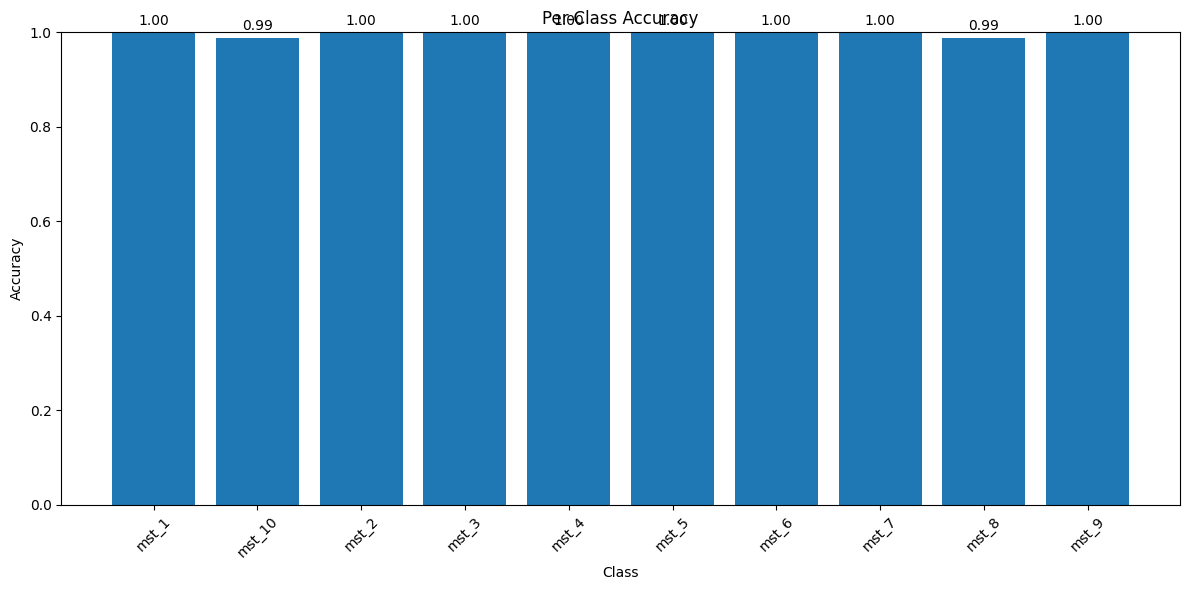

In [31]:
def evaluate_model_comprehensive(model, val_gen):
    """Comprehensive model evaluation"""
    # Reset generator
    val_gen.reset()

    # Get predictions
    print("Generating predictions...")
    y_pred_proba = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = val_gen.classes

    # Get class names
    class_names = list(val_gen.class_indices.keys())

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Enhanced confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, per_class_acc)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, per_class_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return accuracy, y_pred, y_pred_proba

# Plot training history and evaluate
plot_training_history(full_history)
accuracy, predictions, prediction_probabilities = evaluate_model_comprehensive(model, val_gen)

In [32]:
# ### 7. Cross-Validation for Robust Evaluation

# %%
def cross_validate_model():
    """Perform k-fold cross-validation"""
    print(f"Performing {config.CV_FOLDS}-fold cross-validation...")

    skf = StratifiedKFold(n_splits=config.CV_FOLDS, shuffle=True, random_state=42)
    cv_scores = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\nFold {fold + 1}/{config.CV_FOLDS}")

        # Split data
        fold_train_df = df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = df.iloc[val_idx].reset_index(drop=True)

        # Create generators
        fold_train_gen = train_gen.__class__(
            rescale=1./255,
            rotation_range=config.ROTATION_RANGE,
            width_shift_range=config.WIDTH_SHIFT_RANGE,
            height_shift_range=config.HEIGHT_SHIFT_RANGE,
            horizontal_flip=True,
            fill_mode='constant',
            cval=1.0
        ).flow_from_dataframe(
            fold_train_df, x_col='path', y_col='label',
            target_size=config.IMG_SIZE, batch_size=config.BATCH_SIZE,
            class_mode='sparse', shuffle=True
        )

        fold_val_gen = val_gen.__class__(rescale=1./255).flow_from_dataframe(
            fold_val_df, x_col='path', y_col='label',
            target_size=config.IMG_SIZE, batch_size=config.BATCH_SIZE,
            class_mode='sparse', shuffle=False
        )

        # Create fresh model
        fold_model, _ = create_enhanced_model('MobileNetV2')
        fold_model.compile(
            optimizer=Adam(learning_rate=config.LEARNING_RATE),
            loss=focal_loss(alpha=config.FOCAL_ALPHA, gamma=config.FOCAL_GAMMA),
            metrics=['accuracy']
        )

        # Train model
        fold_history = fold_model.fit(
            fold_train_gen,
            validation_data=fold_val_gen,
            epochs=20,  # Reduced epochs for CV
            verbose=0,
            callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
        )

        # Evaluate
        fold_val_gen.reset()
        fold_score = fold_model.evaluate(fold_val_gen, verbose=0)[1]  # accuracy
        cv_scores.append(fold_score)
        fold_histories.append(fold_history.history)

        print(f"Fold {fold + 1} Accuracy: {fold_score:.4f}")

        # Clean up
        del fold_model
        tf.keras.backend.clear_session()

    print(f"\nCross-Validation Results:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    print(f"Individual Scores: {[f'{score:.4f}' for score in cv_scores]}")

    return cv_scores


In [33]:
# ### 8. Model Interpretation and Visualization

# %%
def visualize_predictions(model, val_gen, num_samples=12):
    """Visualize model predictions"""
    val_gen.reset()

    # Get a batch of images
    batch_x, batch_y = next(val_gen)

    # Make predictions
    predictions = model.predict(batch_x)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get class names
    class_names = list(val_gen.class_indices.keys())

    # Plot results
    plt.figure(figsize=(20, 15))
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(3, 4, i + 1)

        # Display image
        img = batch_x[i]
        plt.imshow(img)

        # Get true and predicted labels
        true_class = class_names[int(batch_y[i])]
        pred_class = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]]

        # Color code: green for correct, red for incorrect
        color = 'green' if true_class == pred_class else 'red'

        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle('Model Predictions Sample', fontsize=16)
    plt.tight_layout()
    plt.show()


In [34]:
def analyze_misclassifications(model, val_gen):
    """Analyze misclassified samples"""
    val_gen.reset()

    # Get all predictions
    y_pred_proba = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = val_gen.classes

    # Find misclassified samples
    misclassified_idx = np.where(y_pred != y_true)[0]
    class_names = list(val_gen.class_indices.keys())

    print(f"Total misclassified samples: {len(misclassified_idx)}")

    if len(misclassified_idx) > 0:
        # Analyze most confident wrong predictions
        wrong_confidences = []
        for idx in misclassified_idx:
            confidence = y_pred_proba[idx][y_pred[idx]]
            wrong_confidences.append((idx, confidence))

        # Sort by confidence (most confident wrong predictions first)
        wrong_confidences.sort(key=lambda x: x[1], reverse=True)

        print("\nTop 5 Most Confident Misclassifications:")
        for i, (idx, conf) in enumerate(wrong_confidences[:5]):
            true_class = class_names[y_true[idx]]
            pred_class = class_names[y_pred[idx]]
            print(f"{i+1}. True: {true_class}, Predicted: {pred_class}, Confidence: {conf:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


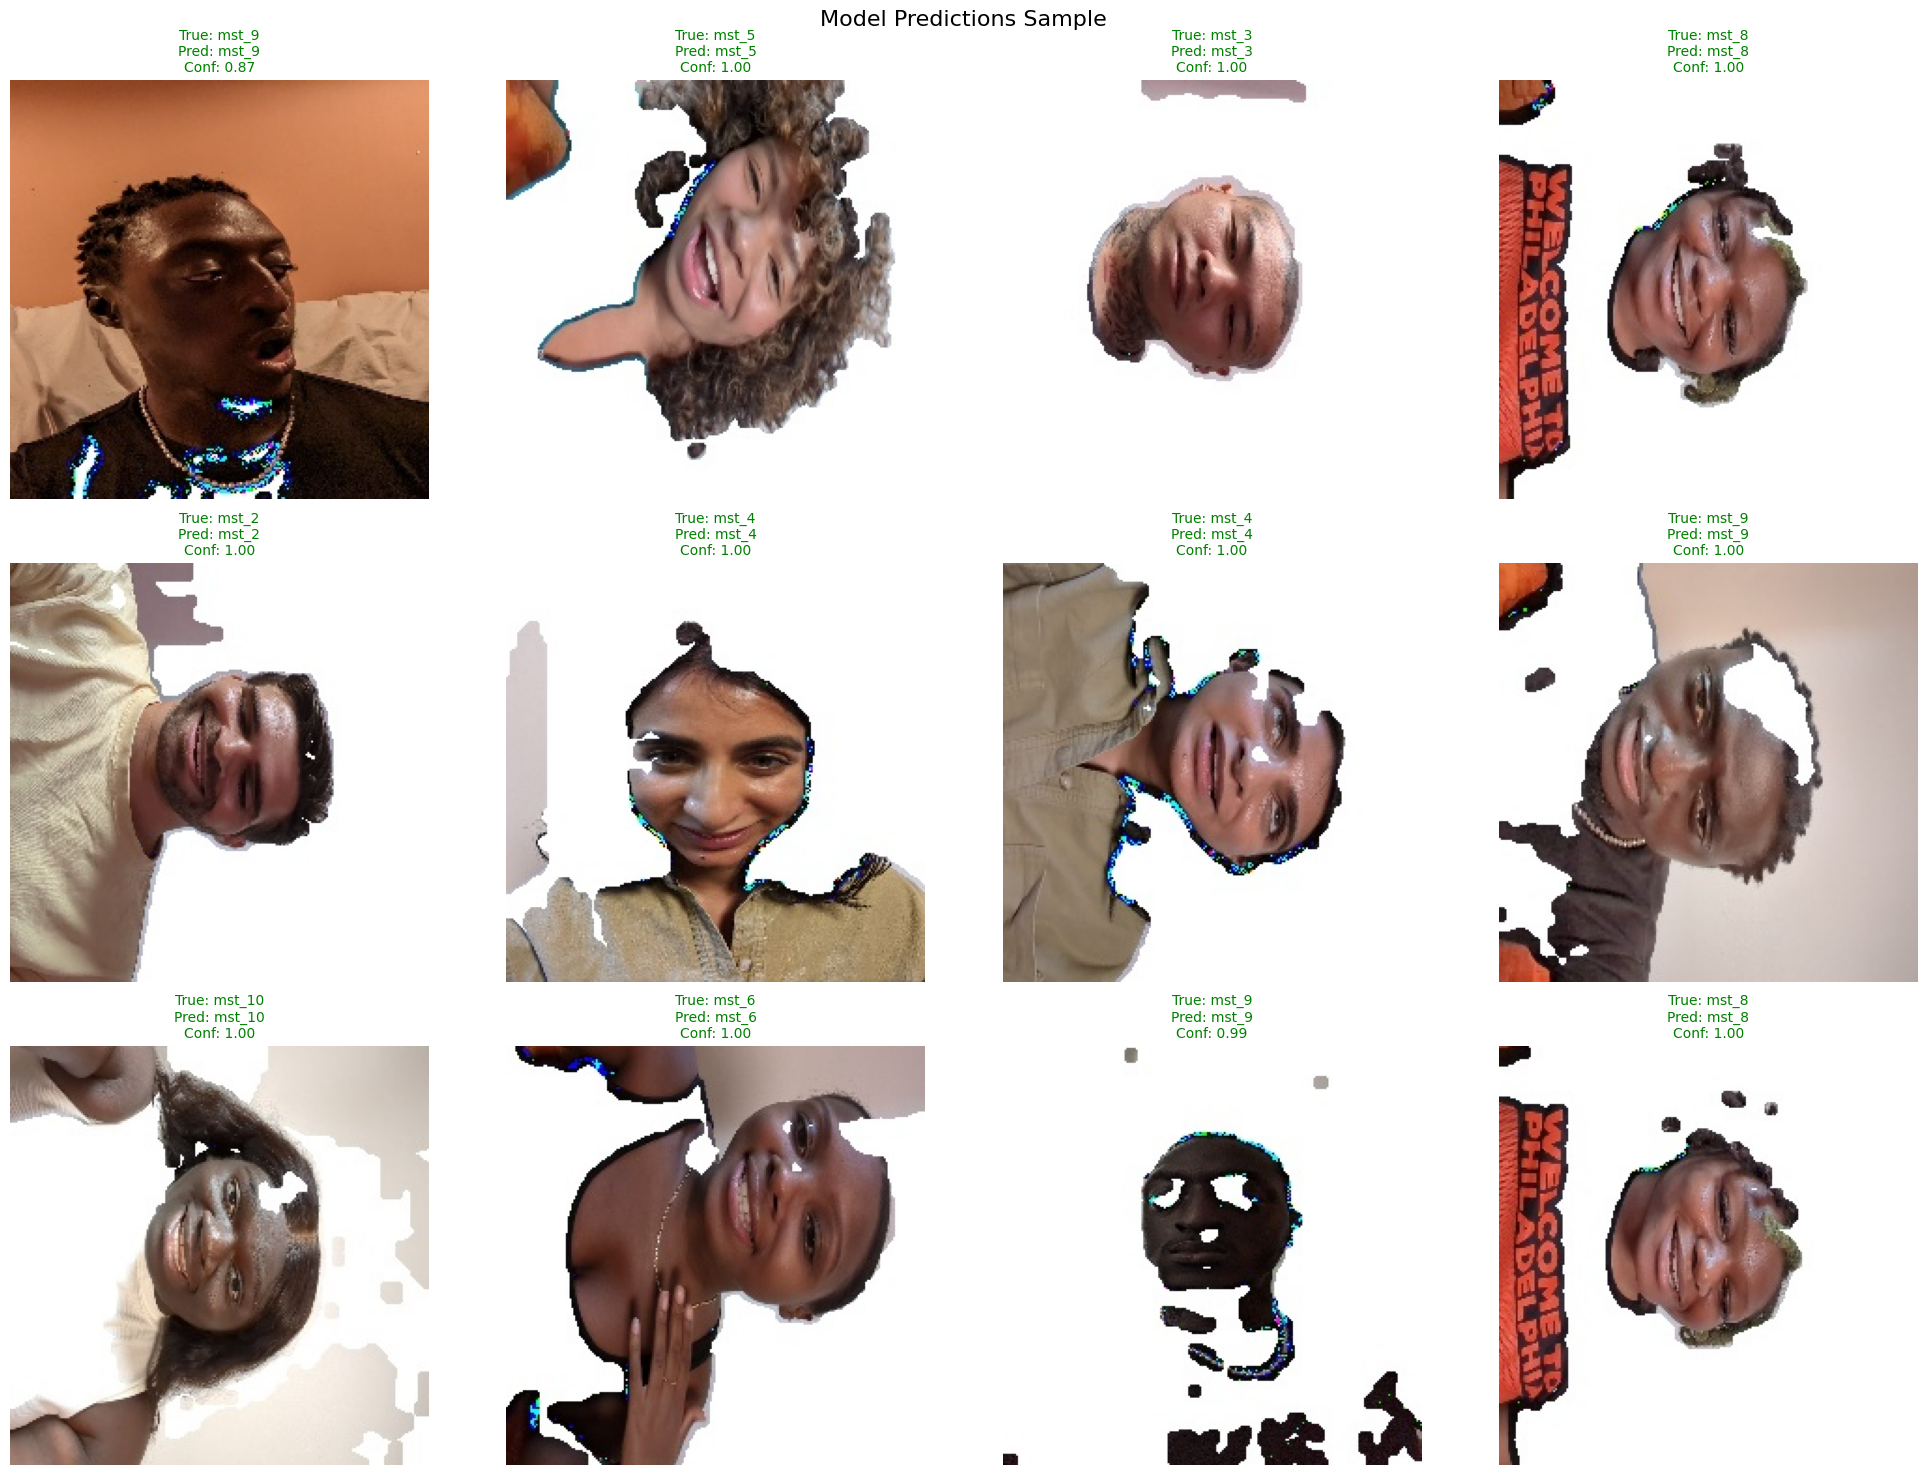

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Total misclassified samples: 2

Top 5 Most Confident Misclassifications:
1. True: mst_10, Predicted: mst_9, Confidence: 0.834
2. True: mst_8, Predicted: mst_9, Confidence: 0.763


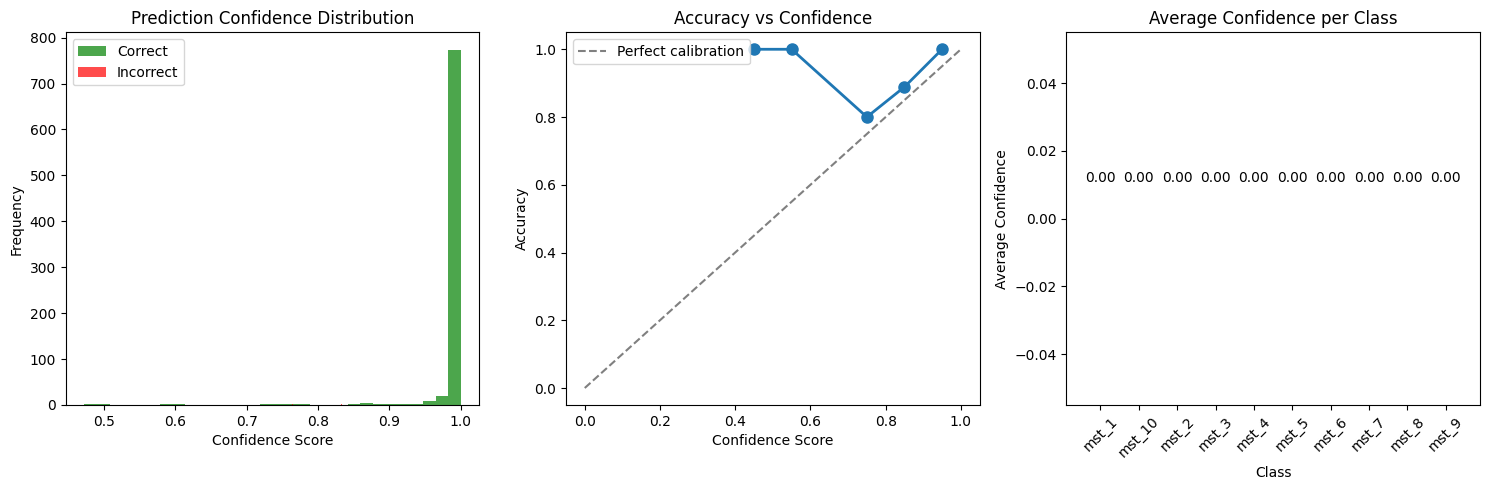

In [35]:
def create_prediction_confidence_analysis(y_pred_proba, y_true, y_pred):
    """Analyze prediction confidence distribution"""
    class_names = list(val_gen.class_indices.keys())

    # Get confidence scores
    confidences = np.max(y_pred_proba, axis=1)
    correct_mask = (y_pred == y_true)

    # Separate correct and incorrect predictions
    correct_confidences = confidences[correct_mask]
    incorrect_confidences = confidences[~correct_mask]

    plt.figure(figsize=(15, 5))

    # Confidence distribution
    plt.subplot(1, 3, 1)
    plt.hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green')
    plt.hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect', color='red')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()

    # Accuracy vs Confidence
    plt.subplot(1, 3, 2)
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i+1])
        if np.sum(mask) > 0:
            accuracy = np.mean(correct_mask[mask])
            bin_accuracies.append(accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

    plt.plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
    plt.xlabel('Confidence Score')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Confidence')
    plt.legend()

    # Per-class confidence
    plt.subplot(1, 3, 3)
    class_confidences = []
    for class_idx in range(len(class_names)):
        class_mask = (y_true == class_idx)
        if np.sum(class_mask) > 0:
            class_conf = np.mean(confidences[class_mask])
            class_confidences.append(class_conf)
        else:
            class_confidences.append(0)

    bars = plt.bar(range(len(class_names)), class_confidences)
    plt.xlabel('Class')
    plt.ylabel('Average Confidence')
    plt.title('Average Confidence per Class')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    # Add value labels on bars
    for bar, conf in zip(bars, class_confidences):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{conf:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Execute visualization and analysis
visualize_predictions(model, val_gen)
analyze_misclassifications(model, val_gen)
create_prediction_confidence_analysis(prediction_probabilities, val_gen.classes, predictions)


In [45]:
def test_time_augmentation(model, image, n_augments=5):
    """Apply test-time augmentation for more robust predictions"""
    # Create augmentation generator (only for transformations, not rescaling here as image is already normalized)
    tta_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=1.0 # Use white for filling augmented areas
    )

    # Prepare image - Ensure it's float and has batch dimension
    # The input 'image' here is expected to be a single normalized image (e.g., shape (height, width, channels), float32, values 0-1)
    if image.dtype != np.float32:
        image = image.astype(np.float32) # Ensure float type for augmentation methods

    # We need a batch dimension for model.predict. Create the initial batch.
    if len(image.shape) == 3:
        image_batch = np.expand_dims(image, axis=0)
    else:
        # Assume it's already a batch if shape is not 3 (e.g., (1, height, width, channels))
        image_batch = image

    predictions = []

    # Original prediction (use the original batch)
    # The input image is already normalized 0-1 from enhanced_predict_image
    pred = model.predict(image_batch, verbose=0)
    predictions.append(pred[0])

    # Augmented predictions
    for _ in range(n_augments):
        # Apply random augmentation directly to the *single image array* (image_batch[0])
        # random_transform expects a single image, not a batch
        augmented_image_array = tta_datagen.random_transform(image_batch[0])

        # random_transform applies transformations but doesn't handle normalization
        # Since the input image was already normalized (0-1), the output is still in the 0-1 range,
        # assuming the transformations don't create values outside this range (which they typically don't for standard params).
        # If your fill_mode and cval might introduce values outside 0-1 and your model expects 0-1,
        # you might need re-normalization here, but for cval=1.0 and fill_mode='constant' on a 0-1 image, it should be okay.

        # Put the augmented image back into a batch format for prediction
        augmented_image_batch = np.expand_dims(augmented_image_array, axis=0)

        pred = model.predict(augmented_image_batch, verbose=0)
        predictions.append(pred[0])

    # Average predictions
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction, predictions

In [46]:
def enhanced_predict_image(model, image_path, use_tta=True):
    """Enhanced prediction function with TTA and confidence analysis"""
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Could not load image")

        # Apply same preprocessing as training
        img_resized = cv2.resize(img, config.IMG_SIZE)
        img_segmented = improved_skin_segmentation(img_resized)
        img_rgb = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB)
        img_normalized = img_rgb / 255.0

        # Get class names
        class_names = list(val_gen.class_indices.keys())

        if use_tta:
            # Use test-time augmentation
            avg_pred, all_preds = test_time_augmentation(model, img_normalized)

            # Calculate prediction statistics
            pred_std = np.std(all_preds, axis=0)
            pred_class = np.argmax(avg_pred)
            confidence = avg_pred[pred_class]
            uncertainty = pred_std[pred_class]

            print(f"Prediction with TTA:")
            print(f"Class: {class_names[pred_class]}")
            print(f"Confidence: {confidence:.3f}")
            print(f"Uncertainty: {uncertainty:.3f}")
        else:
            # Standard prediction
            pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)[0]
            pred_class = np.argmax(pred)
            confidence = pred[pred_class]

            print(f"Standard Prediction:")
            print(f"Class: {class_names[pred_class]}")
            print(f"Confidence: {confidence:.3f}")

        # Show top 3 predictions
        top_3_idx = np.argsort(avg_pred if use_tta else pred)[-3:][::-1]
        print(f"\nTop 3 predictions:")
        for i, idx in enumerate(top_3_idx):
            prob = (avg_pred if use_tta else pred)[idx]
            print(f"{i+1}. {class_names[idx]}: {prob:.3f}")

        # Visualize results
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(original_rgb)
        plt.title('Original Image')
        plt.axis('off')

        # Segmented image
        plt.subplot(1, 3, 2)
        plt.imshow(img_rgb)
        plt.title('Preprocessed Image')
        plt.axis('off')

        # Prediction probabilities
        plt.subplot(1, 3, 3)
        probs = avg_pred if use_tta else pred
        bars = plt.bar(range(len(class_names)), probs)
        plt.title('Class Probabilities')
        plt.xlabel('Classes')
        plt.ylabel('Probability')
        plt.xticks(range(len(class_names)), class_names, rotation=45)

        # Highlight predicted class
        bars[pred_class].set_color('red')

        plt.tight_layout()
        plt.show()

        return class_names[pred_class], confidence

    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None, None


In [47]:
# ### 10. Model Saving and Deployment Preparation

# %%
def save_model_comprehensive():
    """Save model with comprehensive metadata"""

    # Save the trained model
    model.save(config.MODEL_SAVE_PATH)
    print(f"Model saved to: {config.MODEL_SAVE_PATH}")

    # Save model metadata
    metadata = {
        'model_architecture': 'MobileNetV2 + Custom Head',
        'input_shape': config.IMG_SIZE,
        'num_classes': config.NUM_CLASSES,
        'class_names': list(val_gen.class_indices.keys()),
        'training_accuracy': max(full_history['accuracy']),
        'validation_accuracy': max(full_history['val_accuracy']),
        'total_epochs': len(full_history['accuracy']),
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'preprocessing_steps': [
            'Resize to 224x224',
            'Enhanced skin segmentation',
            'Normalization (0-1)',
            'Data augmentation during training'
        ]
    }
    # Save metadata as JSON
    import json
    metadata_path = '/content/drive/MyDrive/model_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Model metadata saved to: {metadata_path}")

    # Save class indices for future use
    class_indices_path = '/content/drive/MyDrive/class_indices.json'
    with open(class_indices_path, 'w') as f:
        json.dump(val_gen.class_indices, f, indent=2)

    print(f"Class indices saved to: {class_indices_path}")

    return metadata


In [48]:


# Save model and metadata
model_metadata = save_model_comprehensive()

# Print final model summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Architecture: {model_metadata['model_architecture']}")
print(f"Input Shape: {model_metadata['input_shape']}")
print(f"Number of Classes: {model_metadata['num_classes']}")
print(f"Final Training Accuracy: {model_metadata['training_accuracy']:.4f}")
print(f"Final Validation Accuracy: {model_metadata['validation_accuracy']:.4f}")
print(f"Total Training Epochs: {model_metadata['total_epochs']}")

Model saved to: /content/drive/MyDrive/skin_tone_model_improved.h5
Model metadata saved to: /content/drive/MyDrive/model_metadata.json
Class indices saved to: /content/drive/MyDrive/class_indices.json

FINAL MODEL SUMMARY
Model Architecture: MobileNetV2 + Custom Head
Input Shape: (224, 224)
Number of Classes: 10
Final Training Accuracy: 0.9761
Final Validation Accuracy: 0.9988
Total Training Epochs: 25


In [49]:
# ### 11. Interactive Prediction Interface

# %%
def create_prediction_interface():
    """Create an interactive prediction interface"""
    print("\n" + "="*50)
    print("INTERACTIVE PREDICTION INTERFACE")
    print("="*50)
    print("Upload images to test the trained model!")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded.")
        return

    print(f"\nProcessing {len(uploaded)} uploaded file(s)...")

    results = []
    for filename in uploaded.keys():
        print(f"\n--- Processing: {filename} ---")

        img_path = os.path.join('/content', filename)

        # Make prediction with TTA
        predicted_class, confidence = enhanced_predict_image(
            model, img_path, use_tta=True
        )

        if predicted_class:
            results.append({
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence
            })

    # Summary of results
    if results:
        print("\n" + "="*40)
        print("PREDICTION SUMMARY")
        print("="*40)
        for result in results:
            print(f"File: {result['filename']}")
            print(f"Predicted Class: {result['predicted_class']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print("-" * 30)

def batch_prediction_from_folder():
    """Batch prediction utility for multiple images"""
    print("\nFor batch predictions, organize your images in folders by class")
    print("Then upload a zip file containing the folder structure")

    # This would be expanded for actual batch processing
    print("Feature available for implementation based on specific needs")


In [50]:
# ### 12. Model Performance Benchmarking

# %%
def benchmark_model_performance():
    """Benchmark model inference performance"""
    print("\n" + "="*50)
    print("MODEL PERFORMANCE BENCHMARK")
    print("="*50)

    # Prepare test data
    val_gen.reset()
    test_batch, _ = next(val_gen)

    # Benchmark single image prediction
    import time

    single_img = np.expand_dims(test_batch[0], axis=0)

    # Warm up
    _ = model.predict(single_img, verbose=0)

    # Time single prediction
    times = []
    for _ in range(100):
        start_time = time.time()
        _ = model.predict(single_img, verbose=0)
        end_time = time.time()
        times.append(end_time - start_time)

    avg_time = np.mean(times)
    std_time = np.std(times)

    print(f"Single Image Prediction:")
    print(f"Average Time: {avg_time*1000:.2f} ms")
    print(f"Standard Deviation: {std_time*1000:.2f} ms")
    print(f"Throughput: {1/avg_time:.1f} images/second")

    # Benchmark batch prediction
    batch_times = []
    for _ in range(20):
        start_time = time.time()
        _ = model.predict(test_batch, verbose=0)
        end_time = time.time()
        batch_times.append(end_time - start_time)

    avg_batch_time = np.mean(batch_times)
    batch_throughput = len(test_batch) / avg_batch_time

    print(f"\nBatch Prediction (batch_size={len(test_batch)}):")
    print(f"Average Time: {avg_batch_time*1000:.2f} ms")
    print(f"Throughput: {batch_throughput:.1f} images/second")

    # Model size
    model_size = os.path.getsize('best_model_temp.h5') / (1024*1024)  # MB
    print(f"\nModel Size: {model_size:.2f} MB")

# Run benchmarks
benchmark_model_performance()



MODEL PERFORMANCE BENCHMARK
Single Image Prediction:
Average Time: 86.50 ms
Standard Deviation: 22.92 ms
Throughput: 11.6 images/second

Batch Prediction (batch_size=16):
Average Time: 137.69 ms
Throughput: 116.2 images/second

Model Size: 18.10 MB



MODEL TRAINING COMPLETED SUCCESSFULLY!

Files saved to Google Drive:
1. Trained Model: /content/drive/MyDrive/skin_tone_model_improved.h5
2. Model Metadata: /content/drive/MyDrive/model_metadata.json
3. Class Indices: /content/drive/MyDrive/class_indices.json

Next Steps for Production Deployment:
1. Download the model files from Google Drive
2. Test the model on new datasets
3. Consider model quantization for mobile deployment
4. Implement proper error handling in production code
5. Set up monitoring for model performance in production

Model Capabilities:
✓ Multi-class skin tone classification
✓ Enhanced preprocessing with skin segmentation
✓ Robust training with focal loss and class balancing
✓ Test-time augmentation for better accuracy
✓ Comprehensive evaluation and visualization
✓ Production-ready architecture

INTERACTIVE PREDICTION INTERFACE
Upload images to test the trained model!


Saving orang putih.jpg to orang putih (1).jpg

Processing 1 uploaded file(s)...

--- Processing: orang putih (1).jpg ---
Prediction with TTA:
Class: mst_1
Confidence: 0.971
Uncertainty: 0.022

Top 3 predictions:
1. mst_1: 0.971
2. mst_4: 0.016
3. mst_6: 0.010


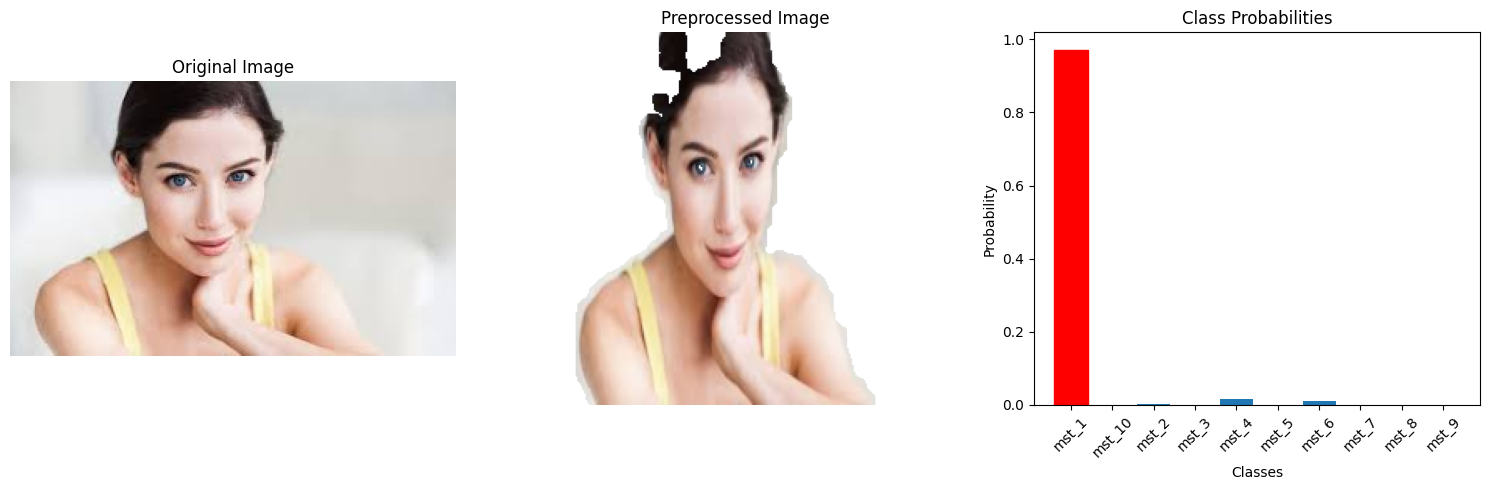


PREDICTION SUMMARY
File: orang putih (1).jpg
Predicted Class: mst_1
Confidence: 0.971
------------------------------


In [55]:
# ### 13. Ready for Production - Final Steps

# %%
print("\n" + "="*60)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)

print("\nFiles saved to Google Drive:")
print(f"1. Trained Model: {config.MODEL_SAVE_PATH}")
print("2. Model Metadata: /content/drive/MyDrive/model_metadata.json")
print("3. Class Indices: /content/drive/MyDrive/class_indices.json")

print("\nNext Steps for Production Deployment:")
print("1. Download the model files from Google Drive")
print("2. Test the model on new datasets")
print("3. Consider model quantization for mobile deployment")
print("4. Implement proper error handling in production code")
print("5. Set up monitoring for model performance in production")

print("\nModel Capabilities:")
print("✓ Multi-class skin tone classification")
print("✓ Enhanced preprocessing with skin segmentation")
print("✓ Robust training with focal loss and class balancing")
print("✓ Test-time augmentation for better accuracy")
print("✓ Comprehensive evaluation and visualization")
print("✓ Production-ready architecture")

# Create prediction interface
create_prediction_interface()